In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


In [2]:
import io
with open('/workspaces/pytorch-gpu-2/preprocessing/data/caida/20251001.as-org2info.txt', 'r', newline='', encoding='utf-8') as input_file:
    lines = input_file.readlines()   
    # Buffers initialisieren
    aut_lines = []
    org_lines = []
    mode = None
    total_lines = len(lines)
    aut_count = 0
    org_count = 0 

    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith("# format:aut"):
            mode = "aut"
            continue
        elif line.startswith("# format:org_id"):
            mode = "org"
            continue
        elif line.startswith("#") or not line:
            # Andere Kommentar- oder Leerzeilen überspringen
            continue      
        if mode == "aut":
            aut_lines.append(line)
            aut_count += 1
        elif mode == "org":
            org_lines.append(line)
            org_count += 1
    # StringIO-Objekte aus den gesammelten Zeilen bauen
    aut_buffer = io.StringIO("\n".join(aut_lines))
    org_buffer = io.StringIO("\n".join(org_lines))
    # DataFrames einlesen
    aut_df = pd.read_csv(aut_buffer, sep="|",
                        names=["aut", "changed", "aut_name", "org_id", "opaque_id", "source"], usecols=["aut", "org_id", "source", "changed"])
    org_df = pd.read_csv(org_buffer, sep="|",
                        names=["org_id", "changed", "org_name", "country", "source"], usecols=["org_id", "org_name", "country"])

    # Join the DataFrames
    joined_df = pd.merge(aut_df, org_df, on="org_id", how="left")
joined_df.head()

,aut,changed,org_id,source,org_name,country
0,1,20240618.0,LPL-141-ARIN,ARIN,"Level 3 Parent, LLC",US
1,2,20231108.0,UNIVER-19-Z-ARIN,ARIN,University of Delaware,US
2,3,20100927.0,MIT-2-ARIN,ARIN,Massachusetts Institute of Technology,US
3,4,20230929.0,USC-32-Z-ARIN,ARIN,University of Southern California,US
4,5,20200723.0,WGL-117-ARIN,ARIN,WFA Group LLC,US


In [3]:
peering_df_joined = pd.merge(net_df, joined_df, left_on='asn', right_on='aut', how='left')
peering_df_joined = peering_df_joined[['asn', 'org_name', 'country', 'source', 'info_type']]
peering_df_joined.head()

,asn,org_name,country,source,info_type
0,4436,"GTT Americas, LLC",US,ARIN,NSP
1,20940,Akamai International B.V.,NL,RIPE,Content
2,31800,DALnet,US,ARIN,Non-Profit
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP


In [4]:
import requests
import json
import pandas as pd
next_page = True
nodes = []
first=5000
offset=0
while(next_page):
    print(f"Fetching AS Rank data: first={first}, offset={offset}")
    response = requests.get(f"https://api.asrank.caida.org/v2/restful/asns/?first={first}&offset={offset}")

    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}")

    as_rank_dump = response.json()
    nodes.extend(as_rank_dump['data']['asns']['edges'])
    if not as_rank_dump['data']['asns']['pageInfo']['hasNextPage']:
        next_page = False
    offset += first

edges = [e['node'] for e in nodes]
as_rank_df = pd.DataFrame(edges)
# 1️⃣ asnDegree (dict) in eigene Spalten auflösen
asnDegree_df = as_rank_df["asnDegree"].apply(pd.Series)
asnDegree_df.columns = [f"asnDegree_{c}" for c in asnDegree_df.columns]

# 2️⃣ wieder an den Haupt-DataFrame anhängen
as_rank_df = pd.concat([as_rank_df.drop(columns=["asnDegree"]), asnDegree_df], axis=1)

# 1️⃣ asnDegree (dict) in eigene Spalten auflösen
asnCone_df = as_rank_df["cone"].apply(pd.Series)
asnCone_df.columns = [f"cone_{c}" for c in asnCone_df.columns]

# 2️⃣ wieder an den Haupt-DataFrame anhängen
as_rank_df = pd.concat([as_rank_df.drop(columns=["cone"]), asnCone_df], axis=1)

# show a quick preview
as_rank_df

Fetching AS Rank data: first=5000, offset=0


KeyboardInterrupt: 

In [4]:
as_rank_df = pd.read_csv('/workspaces/pytorch-gpu-2/preprocessing/data/as_rank_df.csv')
as_rank_df.head()

,asn,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,3356,1,6613,6545,68,0,53986,873410,3468642119
1,1299,2,2567,2509,58,0,41193,776707,3219679484
2,174,3,6723,6626,97,0,38887,730166,3034352967
3,3257,4,1853,1816,37,0,36040,612491,2791999209
4,2914,5,1541,1483,58,0,25179,576134,2918763154


In [5]:
peering_df_joined_with_asrank = pd.merge(
    peering_df_joined,
    as_rank_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank = peering_df_joined_with_asrank.dropna()
peering_df_joined_with_asrank

,asn,org_name,country,source,info_type,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,4436,"GTT Americas, LLC",US,ARIN,NSP,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,31800,DALnet,US,ARIN,Non-Profit,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23620,35359,ADR TEL s.p.a.,IT,RIPE,Cable/DSL/ISP,26962.0,2.0,0.0,0.0,2.0,1.0,8.0,2048.0
23621,26431,Happy Telecommunications LLC,US,ARIN,Content,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23623,210856,Jesse Bakker trading as Skynode,NL,RIPE,NSP,66977.0,1.0,0.0,0.0,1.0,1.0,1.0,256.0
23624,152033,PT Mandari Teknologi Nusantara,ID,APNIC,Cable/DSL/ISP,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# ==== Text + numerische AS-Rank-Features: robustes, korrigiertes Training ====
import os, numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoModel, TrainingArguments, Trainer, EarlyStoppingCallback, AdamW
)
import joblib

# --------- Konfig ---------
MODEL_NAME   = "xlm-roberta-base"
MAX_LENGTH   = 64
LR_BACKBONE  = 5e-6          # Basis-LR für den Backbone nach Unfreeze
LR_HEAD      = 2e-4          # höhere LR für Kopf/Num-Proj beim Warmup; nach Unfreeze kleiner
EPOCHS_WARM  = 2             # 1–2 Epochen: nur Kopf trainieren
EPOCHS_MAIN  = 8             # 6–10: gesamtes Modell mit LLRD
BATCH_SIZE   = 8
WARMUP_RATIO = 0.06
SEED         = 100
OUT_DIR      = "xlmr_org_trainer_out_mixed_fix"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --------- Daten ---------
df = peering_df_joined_with_asrank.copy()
df = df.reset_index(drop=True)   # Index zurücksetzen

# Label
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["info_type"].astype(str))
df["peer_ratio"] = df["asnDegree_peer"] / (df["asnDegree_total"] + 1)
df["cust_ratio"] = df["asnDegree_customer"] / (df["asnDegree_total"] + 1)
df["prov_ratio"] = df["asnDegree_provider"] / (df["asnDegree_total"] + 1)
df["cone_ratio"] = df["cone_numberAsns"] / (df["asnDegree_total"] + 1)
df["addr_per_prefix"] = df["cone_numberAddresses"] / (df["cone_numberPrefixes"] + 1)
num_labels = len(le.classes_)
id2label = {i: c for i,c in enumerate(le.classes_)}
label2id = {c: i for i,c in enumerate(le.classes_)}

# Text
def norm_name(s: str) -> str:
    s = str(s).strip().lower()
    s = " ".join(s.split())
    return s or "unknown"
df["org_name"] = df["org_name"].fillna("unknown").astype(str).map(norm_name)

# Numerische Features
FEAT_COLS = [
    "rank",
    "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
    "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses", "peer_ratio","cust_ratio","prov_ratio","cone_ratio","addr_per_prefix"
]
num_df = df[FEAT_COLS].copy()
for c in FEAT_COLS:
    v = pd.to_numeric(num_df[c], errors="coerce").fillna(0)
    # starke Schiefe log1p-transformieren
    if c.startswith("asnDegree") or c.startswith("cone_number") or c == "rank":
        num_df[c] = np.log1p(v)
    else:
        num_df[c] = v

# Split (stratifiziert)
train_idx, eval_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.13,
    random_state=SEED,
    stratify=df["label_id"]
)
y_train_np  = df.loc[train_idx, "label_id"].to_numpy()
y_eval_np   = df.loc[eval_idx,  "label_id"].to_numpy()

texts_train = df.loc[train_idx, "org_name"].tolist()
texts_eval  = df.loc[eval_idx,  "org_name"].tolist()

Xnum_train_raw = num_df.loc[train_idx].to_numpy(dtype=np.float32)
Xnum_eval_raw  = num_df.loc[eval_idx].to_numpy(dtype=np.float32)

# Standardisieren: nur auf Train fitten!
scaler = StandardScaler()
Xnum_train = scaler.fit_transform(Xnum_train_raw)
Xnum_eval  = scaler.transform(Xnum_eval_raw)

# Tokenizer & Encodings (Padding übernimmt Collator)
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
enc_train = tok(texts_train, truncation=True, max_length=MAX_LENGTH)
enc_eval  = tok(texts_eval,  truncation=True, max_length=MAX_LENGTH)

# Dataset
class TextNumDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, num_feats, labels):
        self.enc = encodings
        self.num = num_feats
        self.y   = labels
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        item = {k: self.enc[k][idx] for k in self.enc}  # plain Python lists
        item["features"] = self.num[idx]                # np.ndarray row
        item["labels"]   = int(self.y[idx])
        return item

ds_train = TextNumDataset(enc_train, Xnum_train, y_train_np)
ds_eval  = TextNumDataset(enc_eval,  Xnum_eval,  y_eval_np)

# Collator
class MixedCollator:
    def __init__(self, tokenizer): self.tok = tokenizer
    def __call__(self, batch):
        text = {k: [b[k] for b in batch] for k in ["input_ids","attention_mask"]}
        text = self.tok.pad(text, return_tensors="pt")
        text["features"] = torch.tensor([b["features"] for b in batch], dtype=torch.float)
        text["labels"]   = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
        return text

collator = MixedCollator(tok)

# Modell
class TextPlusNumClassifier(nn.Module):
    def __init__(self, model_name, num_labels, num_num_feats, dropout=0.2, attn_temp=1.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden = self.backbone.config.hidden_size  # 768 für XLM-R base

        # 🔹 Einfaches Attention-Pooling (learned token weights)
        self.attn = nn.Linear(hidden, 1)
        self.attn_temp = attn_temp  # z.B. 1.0; 0.7 = „breiter“, 1.5 = „spitzer“

        # 🔹 Numerik-Projektion (gibt den Zahlen „Stimme“)
        self.num_proj = nn.Sequential(
            nn.Linear(num_num_feats, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.Dropout(0.1),
        )

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden + 128, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_labels),
        )

    def forward(self, input_ids=None, attention_mask=None, features=None, labels=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        last = out.last_hidden_state                        # [B,T,H]

        # 🔹 Attention-Pooling
        scores = self.attn(last).squeeze(-1)                # [B,T]
        scores = scores / self.attn_temp
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = scores.softmax(dim=-1).unsqueeze(-1)      # [B,T,1]
        pooled = (last * weights).sum(1)                    # [B,H]

        # 🔹 Numerische Features (sollten float sein)
        num_emb = self.num_proj(features)                   # [B,128]

        # 🔹 Fusion + Klassifikation
        z = torch.cat([pooled, num_emb], dim=1)             # [B,H+128]
        logits = self.classifier(self.dropout(z))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}


model = TextPlusNumClassifier(MODEL_NAME, num_labels=num_labels, num_num_feats=Xnum_train.shape[1]).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  float(accuracy_score(labels, preds)),
        "f1_macro":  float(f1_score(labels, preds, average="macro")),
        "precision": float(precision_score(labels, preds, average="macro", zero_division=0)),
        "recall":    float(recall_score(labels, preds, average="macro")),
    }

# ---------------------------
# 1) HEAD-ONLY WARMUP (Backbone gefroren)
# ---------------------------
for p in model.backbone.parameters():  # Backbone einfrieren
    p.requires_grad = False

args_warm = TrainingArguments(
    output_dir=OUT_DIR + "/warmup",
    num_train_epochs=EPOCHS_WARM,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_HEAD,                 # Kopf darf schneller lernen
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=WARMUP_RATIO,
    fp16=False,                            # stabil
    weight_decay=0.01,
    logging_steps=100,
    seed=SEED,
    report_to=["none"],
)

trainer_warm = Trainer(
    model=model,
    args=args_warm,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\n=== Head-only Warmup ===")
trainer_warm.train()
print("Warmup Eval:", trainer_warm.evaluate())

# ---------------------------
# 2) UNFREEZE + LLRD (Layer-wise LR Decay)
# ---------------------------
for p in model.backbone.parameters():
    p.requires_grad = True

# LLRD: untere Layer kleinere LR, Head größere LR
param_groups = []
nL = model.backbone.config.num_hidden_layers
# Encoder-Layer
for i in range(nL):
    params_i = [p for n,p in model.backbone.named_parameters() if f"encoder.layer.{i}." in n]
    if params_i:
        param_groups.append({"params": params_i, "lr": LR_BACKBONE * (0.9 ** (nL - 1 - i))})
# Embeddings
emb_params = [p for n,p in model.backbone.named_parameters() if "embeddings" in n]
if emb_params:
    param_groups.append({"params": emb_params, "lr": LR_BACKBONE * (0.9 ** nL)})
# Kopf (num_proj + classifier) mit höherer LR
head_params = [p for n,p in model.named_parameters() if ("num_proj" in n) or ("classifier" in n)]
param_groups.append({"params": head_params, "lr": LR_BACKBONE * 8})

optimizer = AdamW(param_groups, weight_decay=0.01)

args_main = TrainingArguments(
    output_dir=OUT_DIR + "/checkpoints",
    num_train_epochs=EPOCHS_MAIN,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_BACKBONE,            # wird von param_groups überschrieben
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=WARMUP_RATIO,
    fp16=False,
    weight_decay=0.01,
    logging_steps=100,
    seed=SEED,
    report_to=["none"],
)

trainer = Trainer(
    model=model,
    args=args_main,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(optimizer, None),          # <- unser LLRD-Optimizer
)

print("\n=== Unfreeze + LLRD ===")
trainer.train()
print("Final Eval:", trainer.evaluate())

# Speichern
os.makedirs(OUT_DIR + "/model", exist_ok=True)
trainer.save_model(OUT_DIR + "/model")
tok.save_pretrained(OUT_DIR + "/model")
joblib.dump({"scaler": scaler, "feat_cols": FEAT_COLS, "label_encoder": le}, OUT_DIR + "/model/aux.pkl")
print("Gespeichert nach:", OUT_DIR + "/model")


/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


/home/vscode/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



=== Head-only Warmup ===


/tmp/ipykernel_11648/2049736292.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  text["features"] = torch.tensor([b["features"] for b in batch], dtype=torch.float)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,1.456200,1.380507,0.526472,0.137821,0.253440,0.141601
2,1.382100,1.353241,0.537652,0.164992,0.263035,0.167714


Warmup Eval: {'eval_loss': 1.3532410860061646, 'eval_accuracy': 0.537652088128905, 'eval_f1_macro': 0.16499211021832572, 'eval_precision': 0.26303475852166525, 'eval_recall': 0.16771433460121685, 'eval_runtime': 1.2775, 'eval_samples_per_second': 2380.448, 'eval_steps_per_second': 75.147, 'epoch': 2.0}

=== Unfreeze + LLRD ===


/home/vscode/.local/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,1.283300,1.231743,0.575140,0.258075,0.329837,0.258658
2,1.253800,1.195663,0.582703,0.286770,0.329178,0.281506
3,1.195700,1.175811,0.593555,0.336679,0.391802,0.324253
4,1.172700,1.174051,0.595528,0.392117,0.422640,0.385283
5,1.150500,1.168269,0.596514,0.378632,0.396155,0.391379
6,1.166400,1.157997,0.603091,0.387022,0.421705,0.386055
7,1.144300,1.159214,0.603749,0.381807,0.412501,0.386214


Final Eval: {'eval_loss': 1.1740511655807495, 'eval_accuracy': 0.5955277869122, 'eval_f1_macro': 0.3921167329524947, 'eval_precision': 0.42263982952470497, 'eval_recall': 0.3852830540361752, 'eval_runtime': 1.2222, 'eval_samples_per_second': 2488.037, 'eval_steps_per_second': 78.544, 'epoch': 7.0}
Gespeichert nach: xlmr_org_trainer_out_mixed_fix/model


In [8]:
# ==== Light Ensembling: HF (Text+Num) + XGBoost/RandomForest auf Numeric ====
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) HF-Probabilitäten (Softmax über Logits)
pred = trainer.predict(ds_eval)  # enthält .predictions (logits) & .label_ids
logits = pred.predictions
probs_hf = np.exp(logits - logits.max(axis=1, keepdims=True))
probs_hf = probs_hf / probs_hf.sum(axis=1, keepdims=True)
y_true   = pred.label_ids

# 2) Zweitmodell auf numerischen Features: XGBoost, sonst RandomForest
clf_name = None

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=800, max_depth=None,
    class_weight="balanced_subsample", n_jobs=-1, random_state=42
)
clf_name = "RandomForest"

clf.fit(Xnum_train, y_train_np)

# 2b) Ensure: proba-Aligment auf die globale Klassenreihenfolge
def probs_aligned(clf, X, global_classes):
    """Align predict_proba Spalten auf global_classes-Reihenfolge."""
    p = clf.predict_proba(X)
    # sklearn/xgb liefern eigene class_ Ordnung:
    model_classes = clf.classes_
    out = np.zeros((p.shape[0], len(global_classes)), dtype=float)
    colmap = {c:i for i,c in enumerate(model_classes)}
    for j, c in enumerate(global_classes):
        if c in colmap:
            out[:, j] = p[:, colmap[c]]
        else:
            # falls Klasse im Train fehlte: 0-Proba
            out[:, j] = 0.0
    # numerische Stabilität
    row_sum = out.sum(axis=1, keepdims=True)
    mask = row_sum.squeeze(-1) > 0
    out[mask] /= row_sum[mask]
    # falls Zeile Summe=0 (extremer Randfall): gleich verteilen
    out[~mask] = 1.0/len(global_classes)
    return out

probs_num = probs_aligned(clf, Xnum_eval, global_classes=np.arange(len(le.classes_)))

# 3) Baselines drucken
acc_hf  = accuracy_score(y_true, probs_hf.argmax(1))
f1m_hf  = f1_score(y_true, probs_hf.argmax(1), average="macro")
acc_num = accuracy_score(y_true, probs_num.argmax(1))
f1m_num = f1_score(y_true, probs_num.argmax(1), average="macro")

print(f"HF (Text+Num-Netz)     : Acc={acc_hf:.4f}  F1m={f1m_hf:.4f}")
print(f"{clf_name:>18s} only : Acc={acc_num:.4f}  F1m={f1m_num:.4f}")

# 4) Gewichtetes Mischen (alpha = Anteil HF)
alphas = [0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5]
best = (-1, -1, None)  # (acc, f1m, alpha)
for a in alphas:
    probs_ens = a*probs_hf + (1-a)*probs_num
    y_pred = probs_ens.argmax(1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"Ensemble a={a:.2f}     : Acc={acc:.4f}  F1m={f1m:.4f}")
    if (acc, f1m) > (best[0], best[1]):
        best = (acc, f1m, a)

print("\nBest Ensemble:")
print(f"a={best[2]:.2f}  Acc={best[0]:.4f}  F1m={best[1]:.4f}")

# Optional: detaillierter Report des besten Mischgewichts
a = best[2]
probs_best = a*probs_hf + (1-a)*probs_num
y_pred_best = probs_best.argmax(1)
print("\nPer-Class Report (best a):")
print(classification_report(y_true, y_pred_best, target_names=list(le.classes_), zero_division=0))


HF (Text+Num-Netz)     : Acc=0.5919  F1m=0.3833
      RandomForest only : Acc=0.3930  F1m=0.1709
Ensemble a=0.90     : Acc=0.5982  F1m=0.3837
Ensemble a=0.85     : Acc=0.6014  F1m=0.3837
Ensemble a=0.80     : Acc=0.5975  F1m=0.3818
Ensemble a=0.75     : Acc=0.5972  F1m=0.3804
Ensemble a=0.70     : Acc=0.5968  F1m=0.3808
Ensemble a=0.60     : Acc=0.5936  F1m=0.3690
Ensemble a=0.50     : Acc=0.5807  F1m=0.3401

Best Ensemble:
a=0.85  Acc=0.6014  F1m=0.3837

Per-Class Report (best a):
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.68      0.86      0.76      1521
             Content       0.37      0.40      0.39       320
Educational/Research       0.59      0.73      0.65       184
          Enterprise       0.36      0.28      0.31       221
          Government       0.62      0.62      0.62        16
                 NSP       0.56      0.26      0.35       515
    Network Services       0.00      0.00      0.00       102
          Non-Pr

In [9]:
# ==== Stacking: Meta-LogReg lernt Kombination aus HF- und Numeric-Modell ====
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import joblib

# 0) Helper: Spalten der predict_proba an globale Klassenordnung angleichen
def probs_aligned(clf, X, global_classes):
    p = clf.predict_proba(X)
    model_classes = clf.classes_
    out = np.zeros((p.shape[0], len(global_classes)), dtype=float)
    colmap = {c:i for i,c in enumerate(model_classes)}
    for j, c in enumerate(global_classes):
        if c in colmap:
            out[:, j] = p[:, colmap[c]]
        else:
            out[:, j] = 0.0
    row_sum = out.sum(axis=1, keepdims=True)
    mask = row_sum.squeeze(-1) > 0
    out[mask] /= row_sum[mask]
    out[~mask] = 1.0/len(global_classes)
    return out

# 1) HF-Wahrscheinlichkeiten (Train + Eval)
pred_tr = trainer.predict(ds_train)
pred_ev = trainer.predict(ds_eval)

logits_tr = pred_tr.predictions
logits_ev = pred_ev.predictions

# numerisch stabile Softmax
probs_hf_tr = np.exp(logits_tr - logits_tr.max(axis=1, keepdims=True))
probs_hf_tr /= probs_hf_tr.sum(axis=1, keepdims=True)

probs_hf_ev = np.exp(logits_ev - logits_ev.max(axis=1, keepdims=True))
probs_hf_ev /= probs_hf_ev.sum(axis=1, keepdims=True)

y_true_tr = pred_tr.label_ids
y_true_ev = pred_ev.label_ids

# 2) Zweitmodell auf Numeric-Features (nimm dein vorhandenes; sonst RF)
try:
    clf  # falls du schon einen (XGB/RF) aus dem vorherigen Schritt hast
except NameError:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        n_estimators=800,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    clf.fit(Xnum_train, y_train_np)

probs_num_tr = probs_aligned(clf, Xnum_train, global_classes=np.arange(len(le.classes_)))
probs_num_ev = probs_aligned(clf, Xnum_eval,  global_classes=np.arange(len(le.classes_)))

# 3) Meta-Features: concat der Basis-Wahrscheinlichkeiten
X_meta_tr = np.hstack([probs_hf_tr, probs_num_tr])
X_meta_ev = np.hstack([probs_hf_ev, probs_num_ev])

# 4) Meta-Learner (multinomial LogReg). Kein class_weight hier: Inputs sind schon Probabilitäten.
meta = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    solver="lbfgs"   # stabil für multinomial
)
meta.fit(X_meta_tr, y_true_tr)

y_pred_stack = meta.predict(X_meta_ev)

acc = accuracy_score(y_true_ev, y_pred_stack)
f1m = f1_score(y_true_ev, y_pred_stack, average="macro")
print(f"STACKING  Acc={acc:.4f}  F1m={f1m:.4f}")
print("\nPer-Class Report:")
print(classification_report(y_true_ev, y_pred_stack, target_names=list(le.classes_), zero_division=0))

# 5) Optional: speichern für Deployment
joblib.dump(
    {"meta": meta, "base_numeric": clf, "label_encoder": le},
    OUT_DIR + "/model/stacking.pkl"
)
print("Stacking artefacts saved to", OUT_DIR + "/model/stacking.pkl")


STACKING  Acc=0.5587  F1m=0.3391

Per-Class Report:
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.63      0.84      0.72      1521
             Content       0.33      0.28      0.30       320
Educational/Research       0.57      0.60      0.59       184
          Enterprise       0.38      0.22      0.28       221
          Government       0.71      0.31      0.43        16
                 NSP       0.39      0.23      0.29       515
    Network Services       0.12      0.02      0.03       102
          Non-Profit       0.36      0.17      0.23        78
     Route Collector       0.00      0.00      0.00         4
        Route Server       0.60      0.46      0.52        80

            accuracy                           0.56      3041
           macro avg       0.41      0.31      0.34      3041
        weighted avg       0.51      0.56      0.52      3041

Stacking artefacts saved to xlmr_org_trainer_out_mixed_fix/model/stacking.pkl

In [10]:
# ==== XGB auf [Text-Embeddings || Numeric] + Ensemble mit HF ====
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) Embeddings aus dem bereits trainierten Modell ziehen (CLS)
model.eval()
@torch.no_grad()
def get_embeds(dataset, batch=256):
    embs = []
    for i in range(0, len(dataset), batch):
        batch_items = [dataset[j] for j in range(i, min(i+batch, len(dataset)))]
        enc = tok.pad(
            {"input_ids":[b["input_ids"] for b in batch_items],
             "attention_mask":[b["attention_mask"] for b in batch_items]},
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        # Backbone forward
        out = model.backbone(**enc)
        cls = out.last_hidden_state[:, 0]          # CLS
        embs.append(cls.cpu().numpy())
    return np.vstack(embs)

Xtxt_tr = get_embeds(ds_train)
Xtxt_ev = get_embeds(ds_eval)

# 2) Kombinieren mit numerischen Features
Xcomb_tr = np.hstack([Xtxt_tr, Xnum_train])
Xcomb_ev = np.hstack([Xtxt_ev, Xnum_eval])

# 3) XGBoost (Fallback: RandomForest)
def probs_aligned(clf, X, global_classes):
    p = clf.predict_proba(X)
    model_classes = clf.classes_
    out = np.zeros((p.shape[0], len(global_classes)), dtype=float)
    colmap = {c:i for i,c in enumerate(model_classes)}
    for j, c in enumerate(global_classes):
        out[:, j] = p[:, colmap[c]] if c in colmap else 0.0
    s = out.sum(axis=1, keepdims=True)
    ok = s.squeeze(-1) > 0
    out[ok] /= s[ok]
    out[~ok] = 1.0 / len(global_classes)
    return out

clf_name = None
try:
    import xgboost as xgb
    clf = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        n_estimators=900, max_depth=8, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.0,
        tree_method="gpu_hist",            # falls GPU: "gpu_hist"
        n_jobs=-1, random_state=42
    )
    clf_name = "XGBoost[emb+num]"
except Exception:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        n_estimators=800, class_weight="balanced_subsample",
        n_jobs=-1, random_state=42
    )
    clf_name = "RandomForest[emb+num]"

clf.fit(Xcomb_tr, y_train_np)
probs_xgb = probs_aligned(clf, Xcomb_ev, global_classes=np.arange(len(le.classes_)))

# 4) HF-Probabilitäten holen
pred_ev = trainer.predict(ds_eval)
logits_ev = pred_ev.predictions
probs_hf = np.exp(logits_ev - logits_ev.max(axis=1, keepdims=True))
probs_hf /= probs_hf.sum(axis=1, keepdims=True)
y_true = pred_ev.label_ids

# 5) Einzel-Performance
acc_x = accuracy_score(y_true, probs_xgb.argmax(1))
f1m_x = f1_score(y_true, probs_xgb.argmax(1), average="macro")
acc_h = accuracy_score(y_true, probs_hf.argmax(1))
f1m_h = f1_score(y_true, probs_hf.argmax(1), average="macro")
print(f"{clf_name:20s}: Acc={acc_x:.4f}  F1m={f1m_x:.4f}")
print(f"HF (Text+Num-Netz) : Acc={acc_h:.4f}  F1m={f1m_h:.4f}")

# 6) Ensemble (gewichtetes Mischen der Wahrscheinlichkeiten)
best = (-1, -1, None)
for a in [0.9,0.85,0.8,0.75,0.7,0.6]:
    probs_ens = a*probs_hf + (1-a)*probs_xgb
    y_pred = probs_ens.argmax(1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"Ensemble a={a:.2f}    : Acc={acc:.4f}  F1m={f1m:.4f}")
    if (acc, f1m) > (best[0], best[1]):
        best = (acc, f1m, a)

print("\nBest Ensemble:")
print(f"a={best[2]:.2f}  Acc={best[0]:.4f}  F1m={best[1]:.4f}")

# 7) Report für das beste a
from sklearn.metrics import classification_report
probs_best = best[2]*probs_hf + (1-best[2])*probs_xgb
y_pred_best = probs_best.argmax(1)
print("\nPer-Class Report (best a):")
print(classification_report(y_true, y_pred_best, target_names=list(le.classes_), zero_division=0))


XGBoost[emb+num]    : Acc=0.6162  F1m=0.4400
HF (Text+Num-Netz) : Acc=0.5919  F1m=0.3833
Ensemble a=0.90    : Acc=0.6080  F1m=0.3939
Ensemble a=0.85    : Acc=0.6120  F1m=0.3942
Ensemble a=0.80    : Acc=0.6172  F1m=0.3957
Ensemble a=0.75    : Acc=0.6162  F1m=0.4006
Ensemble a=0.70    : Acc=0.6202  F1m=0.4041
Ensemble a=0.60    : Acc=0.6205  F1m=0.4084

Best Ensemble:
a=0.60  Acc=0.6205  F1m=0.4084

Per-Class Report (best a):
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.67      0.90      0.77      1521
             Content       0.43      0.35      0.39       320
Educational/Research       0.62      0.71      0.66       184
          Enterprise       0.43      0.25      0.32       221
          Government       0.52      0.69      0.59        16
                 NSP       0.55      0.26      0.36       515
    Network Services       0.43      0.06      0.10       102
          Non-Profit       0.53      0.23      0.32        78
     Route Co

In [14]:
# ==== Recall-Finetuning: WeightedRandomSampler +/− Focal Loss ====
import numpy as np, torch, torch.nn as nn
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# -----------------------------
# Toggle: was soll angewendet werden?
USE_SAMPLER = True     # Oversampling seltener Klassen in jedem Batch
USE_FOCAL   = True     # Focal Loss statt CrossEntropy
FOCAL_GAMMA = 1.5      # 1.5–2.0 erhöht Fokus auf „schwere“ Beispiele
FINETUNE_EPOCHS = 4    # kurzer Recall-Boost
FINETUNE_LR     = 3e-6 # sehr kleine LR, damit wir Modell nur fein nachschärfen
OUT_DIR_FT      = OUT_DIR + "/recall_ft"
# -----------------------------

# 1) (Optional) Focal Loss definieren
device = torch.device('cpu')
model.to(device)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")
        self.reduction = reduction
    def forward(self, logits, target):
        ce = self.ce(logits, target)  # [B]
        with torch.no_grad():
            pt = torch.softmax(logits, dim=1)[torch.arange(logits.size(0), device=logits.device), target].clamp(min=1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# 2) Custom-Trainer, der optional Focal Loss nutzt
class RecallTrainer(Trainer):
    def __init__(self, use_focal=False, focal_gamma=2.0, sampler=None, **kwargs):
        super().__init__(**kwargs)
        self.use_focal = use_focal
        self.focal = FocalLoss(gamma=focal_gamma) if use_focal else None
        self._sampler = sampler

    def compute_loss(self, model, inputs, return_outputs=False):
        # labels separieren, um eigenen Loss zu rechnen
        labels = inputs.pop("labels")
        outputs = model(**inputs)  # forward ohne labels -> outputs["logits"]
        logits = outputs["logits"]
        if self.use_focal:
            loss = self.focal(logits, labels)
        else:
            loss = nn.CrossEntropyLoss()(logits, labels)
        if return_outputs:
            outputs["loss"] = loss
            return loss, outputs
        return loss

    # optional eigener Train-DataLoader mit Sampler
    def get_train_dataloader(self):
        if self.train_dataset is None:
            return None
        if self._sampler is None:
            return super().get_train_dataloader()
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=self._sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

# 3) Sampler vorbereiten (inverse Häufigkeit^alpha). alpha ~ 0.7 balanciert gut.
sampler = None
if USE_SAMPLER:
    counts = np.bincount(y_train_np, minlength=len(le.classes_)).astype(np.float64)
    inv_freq = 1.0 / np.maximum(counts, 1.0)
    alpha = 0.7
    class_w = (inv_freq ** alpha)
    class_w = class_w / class_w.mean()
    sample_w = torch.tensor([class_w[y] for y in y_train_np], dtype=torch.float)
    sampler = WeightedRandomSampler(weights=sample_w, num_samples=len(sample_w), replacement=True)
    print("Sampler aktiv: Klassen-Gewichte ~", np.round(class_w, 3))

# 4) Kurze Finetune-Args
args_ft = TrainingArguments(
    output_dir=OUT_DIR_FT,
    num_train_epochs=FINETUNE_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=FINETUNE_LR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=0.0,
    fp16=False,                # stabil halten
    weight_decay=0.0,          # beim Finetune oft 0
    logging_steps=100,
    seed=SEED,
    report_to=["none"],
)

# 5) Trainer aufsetzen (nimmt dein existierendes `model`, `ds_train`, `ds_eval`, `collator`, `tok`)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  float(accuracy_score(labels, preds)),
        "f1_macro":  float(f1_score(labels, preds, average="macro")),
        "precision": float(precision_score(labels, preds, average="macro", zero_division=0)),
        "recall":    float(recall_score(labels, preds, average="macro")),
    }

trainer_recall = RecallTrainer(
    model=model,
    args=args_ft,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    use_focal=USE_FOCAL,
    focal_gamma=FOCAL_GAMMA,
    sampler=sampler
)

print("\n=== Recall-Finetune startet ===")
trainer_recall.train()
print("Recall-Finetune Eval:", trainer_recall.evaluate())

Sampler aktiv: Klassen-Gewichte ~ [0.079 0.237 0.349 0.307 1.89  0.17  0.525 0.634 5.187 0.622]


/home/vscode/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



=== Recall-Finetune startet ===


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacty of 7.62 GiB of which 576.94 MiB is free. Including non-PyTorch memory, this process has 6.93 GiB memory in use. Of the allocated memory 6.57 GiB is allocated by PyTorch, and 203.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

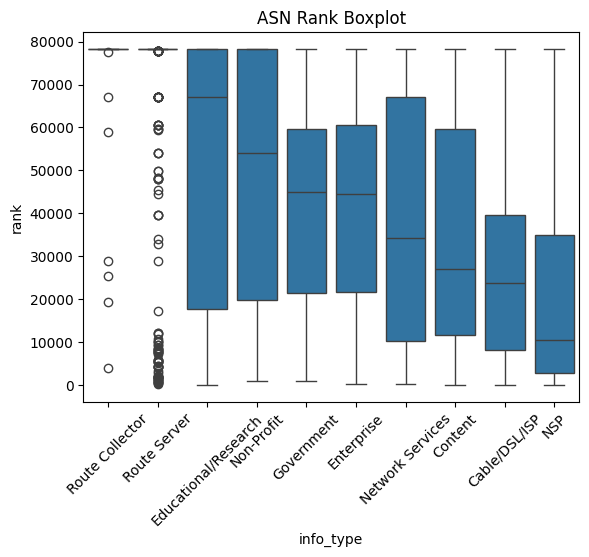

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
order = peering_df_joined_with_asrank.groupby('info_type')['rank'].median().sort_values(ascending=False).index
sns.boxplot(data=peering_df_joined_with_asrank, x='info_type', y='rank', order=order)
plt.xticks(rotation=45)
plt.title('ASN Rank Boxplot')
plt.show()


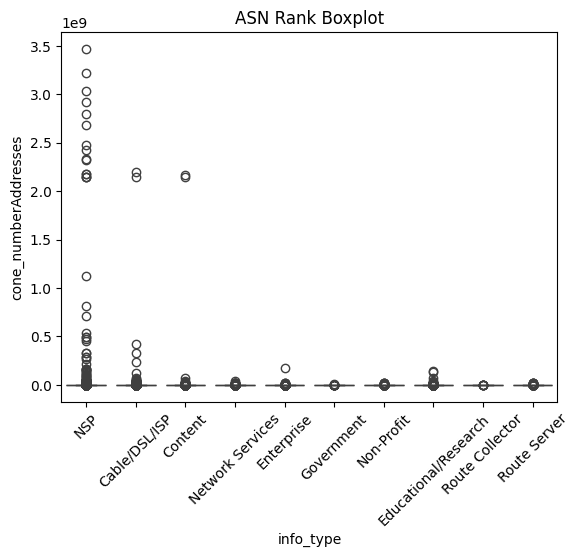

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
order = peering_df_joined_with_asrank.groupby('info_type')['cone_numberAddresses'].median().sort_values(ascending=False).index
sns.boxplot(data=peering_df_joined_with_asrank, x='info_type', y='cone_numberAddresses', order=order)
plt.xticks(rotation=45)
plt.title('ASN Rank Boxplot')
plt.show()


In [18]:
peering_df_joined_with_asrank.head()

,asn,org_name,country,source,info_type,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,4436,"GTT Americas, LLC",US,ARIN,NSP,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,31800,DALnet,US,ARIN,Non-Profit,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0
